Copyright (c) 2024 Godwin Ita
All rights reserved.
Permission is hereby granted, free of charge, to any person obtaining a copy
of this code and associated documentation files (the "code"), to deal
in the code without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the code, and to permit persons to whom the code is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the code.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE

In [ ]:
#Importing all necessary libraries for the investigation

import lasio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from scipy import stats
import itertools

In [ ]:
# Data processing
# loading dataset

ita_well = pd.read_csv('ita.csv')

In [2]:
# creating a pandas data frame from the downloaded LAS files and saving to csv

las1 = lasio.read("input_15_9-F-1.LAS")
las2 = lasio.read("output_15_9-F-1.LAS")
inputlogs= las1.df()
outputlogs= las2.df()
data= pd.merge(inputlogs, outputlogs, on="DEPTH")
data.to_csv('ita.csv', index=False)

In [4]:
ita_well.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3610 entries, 0 to 3609
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ABDCQF01   3386 non-null   float64
 1   ABDCQF02   3386 non-null   float64
 2   ABDCQF03   3386 non-null   float64
 3   ABDCQF04   3386 non-null   float64
 4   BS         3610 non-null   float64
 5   CALI       3379 non-null   float64
 6   DRHO       3386 non-null   float64
 7   DT         3280 non-null   float64
 8   GR         3533 non-null   float64
 9   NPHI       3358 non-null   float64
 10  PEF        3386 non-null   float64
 11  RACEHM     3521 non-null   float64
 12  RACELM     3521 non-null   float64
 13  RD         3521 non-null   float64
 14  RHOB       3386 non-null   float64
 15  RM         3521 non-null   float64
 16  ROP        3610 non-null   float64
 17  RPCEHM     3521 non-null   float64
 18  RPCELM     3521 non-null   float64
 19  RT         3521 non-null   float64
 20  BVW     

In [5]:
#check for missing data
missing_data = ita_well.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data
           [column].value_counts())
    print("")

ABDCQF01
False    3386
True      224
Name: ABDCQF01, dtype: int64

ABDCQF02
False    3386
True      224
Name: ABDCQF02, dtype: int64

ABDCQF03
False    3386
True      224
Name: ABDCQF03, dtype: int64

ABDCQF04
False    3386
True      224
Name: ABDCQF04, dtype: int64

BS
False    3610
Name: BS, dtype: int64

CALI
False    3379
True      231
Name: CALI, dtype: int64

DRHO
False    3386
True      224
Name: DRHO, dtype: int64

DT
False    3280
True      330
Name: DT, dtype: int64

GR
False    3533
True       77
Name: GR, dtype: int64

NPHI
False    3358
True      252
Name: NPHI, dtype: int64

PEF
False    3386
True      224
Name: PEF, dtype: int64

RACEHM
False    3521
True       89
Name: RACEHM, dtype: int64

RACELM
False    3521
True       89
Name: RACELM, dtype: int64

RD
False    3521
True       89
Name: RD, dtype: int64

RHOB
False    3386
True      224
Name: RHOB, dtype: int64

RM
False    3521
True       89
Name: RM, dtype: int64

ROP
False    3610
Name: ROP, dtype: int64

RPCEHM
Fa

In [6]:
# solving the missing data problem, we remove all the missing data

ita_well1 = ita_well.dropna()
ita_well1

,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,GR,NPHI,...,RPCELM,RT,BVW,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
487,2.5269,2.6350,2.6910,2.6595,8.5,8.6250,0.0522,68.4529,129.2796,0.1098,...,1.4654,1.3082,0.0200,0.0,0.0010,0.0200,0.0,1.0,0.0120,0.7446
488,2.5667,2.6699,2.6551,2.6929,8.5,8.6250,0.0698,68.2099,94.5679,0.1054,...,1.5045,1.4833,0.0200,0.0,0.0010,0.0200,0.0,1.0,0.0000,0.7582
489,2.6224,2.6845,2.6010,2.7025,8.5,8.6250,0.0834,67.8057,72.4837,0.1051,...,1.7400,1.9602,0.0200,0.0,0.0017,0.0200,0.0,1.0,0.0339,0.5477
490,2.6772,2.6694,2.5479,2.6810,8.5,8.6250,0.0897,67.1666,58.2152,0.1047,...,1.9330,2.4704,0.0238,0.0,0.0306,0.0238,0.0,1.0,0.1487,0.4117
491,2.7051,2.6360,2.5067,2.6292,8.5,8.6016,0.0875,66.6090,52.7115,0.1061,...,1.9649,2.5638,0.0413,0.0,0.1252,0.0413,0.0,1.0,0.1526,0.3592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,2.6012,2.5989,2.5975,2.6058,8.5,8.6250,0.0581,76.6795,90.2940,0.1634,...,2.1740,2.1991,0.0295,0.0,0.0010,0.0295,0.0,1.0,0.0000,0.6275
3276,2.5997,2.6000,2.6025,2.6060,8.5,8.6250,0.0566,76.3281,85.8942,0.1686,...,2.1993,2.2756,0.0287,0.0,0.0010,0.0287,0.0,1.0,0.0000,0.5908
3277,2.5969,2.5991,2.6078,2.6034,8.5,8.6250,0.0552,76.0730,83.1276,0.1811,...,2.2133,2.3320,0.0287,0.0,0.0010,0.0287,0.0,1.0,0.0020,0.5678
3278,2.5919,2.5961,2.6117,2.5996,8.5,8.6250,0.0539,75.9054,81.5331,0.1977,...,2.2163,2.3674,0.0295,0.0,0.0010,0.0295,0.0,1.0,0.0087,0.5544


C:\Users\godwi\AppData\Local\Temp\ipykernel_11132\3477434700.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # Creates a new figure


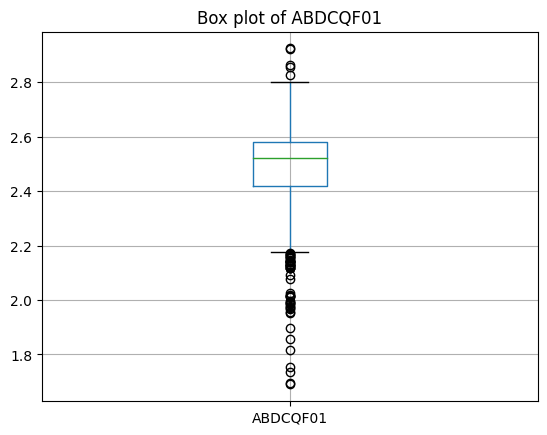

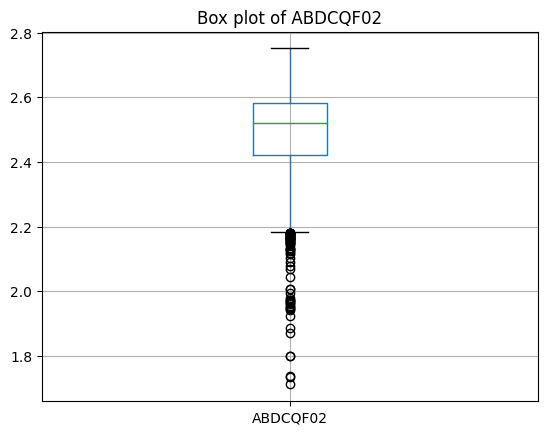

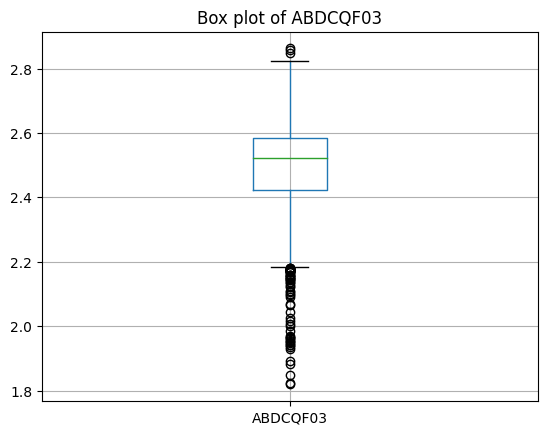

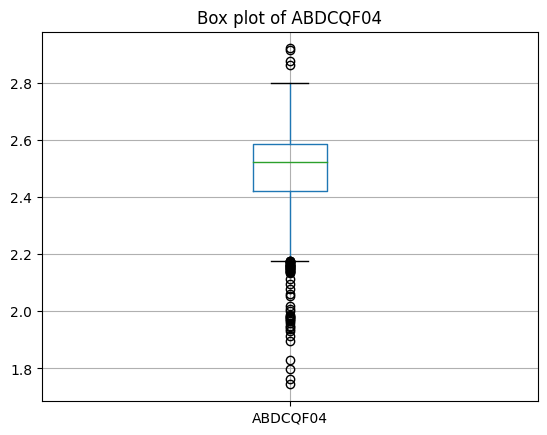

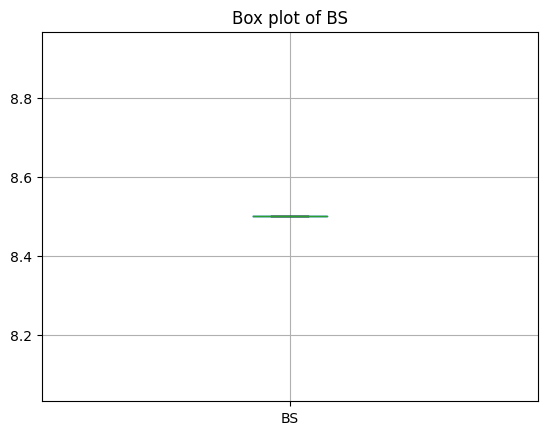

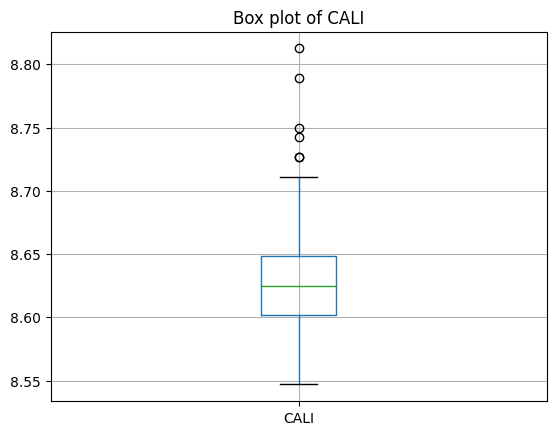

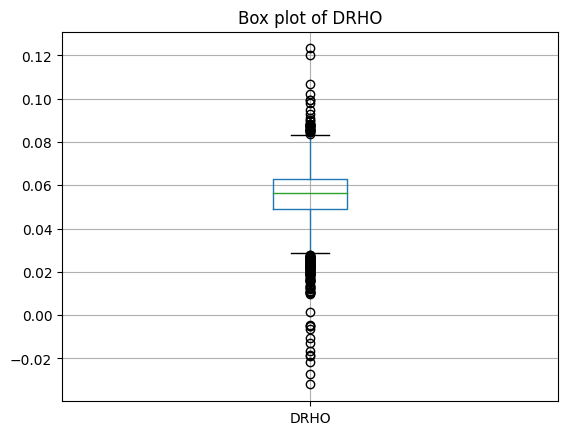

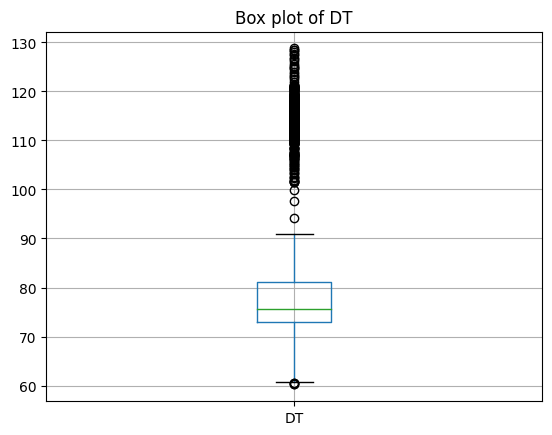

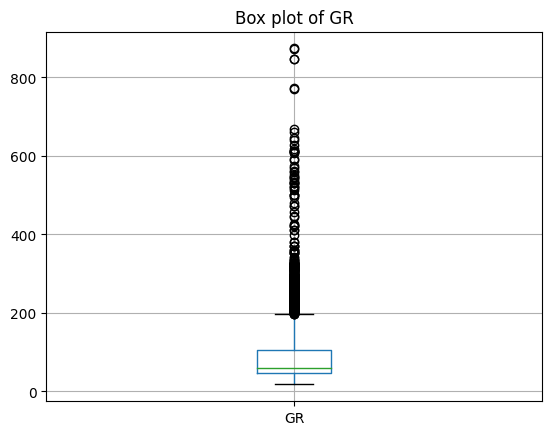

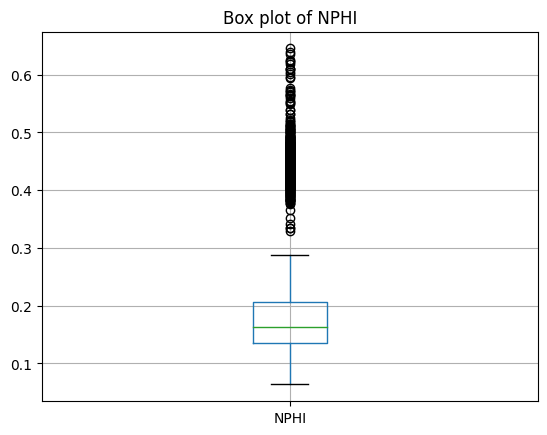

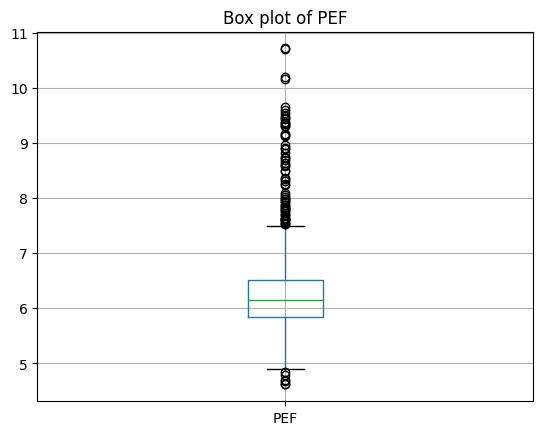

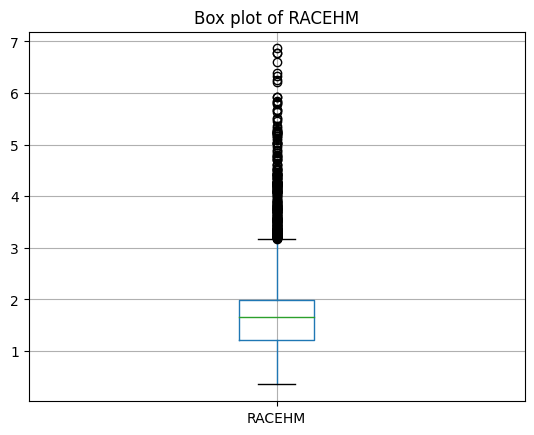

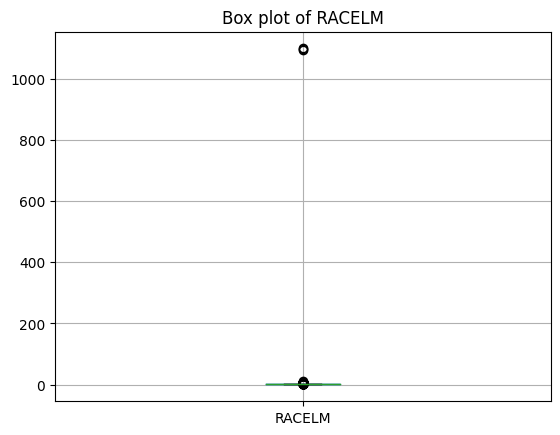

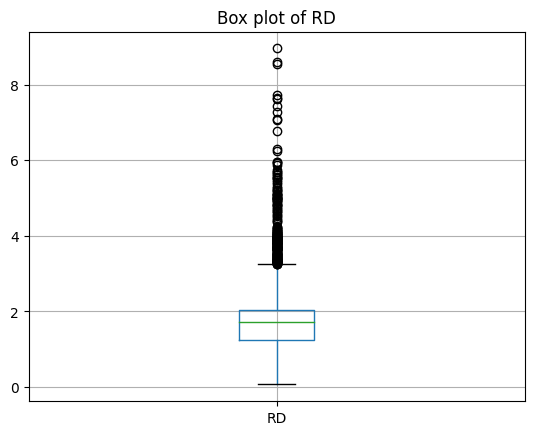

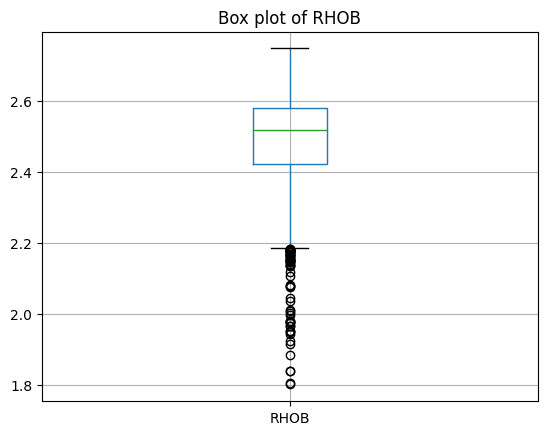

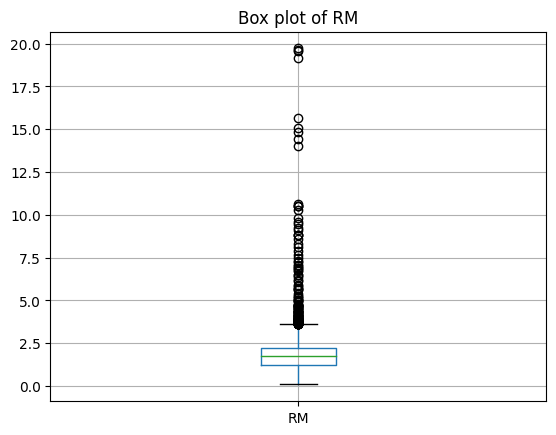

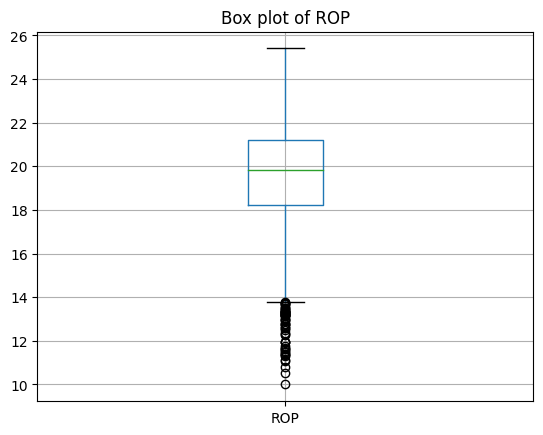

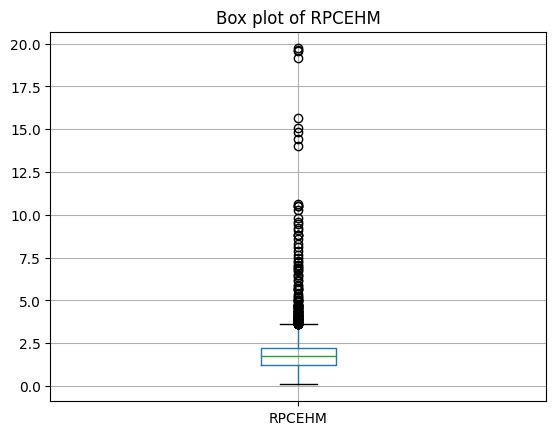

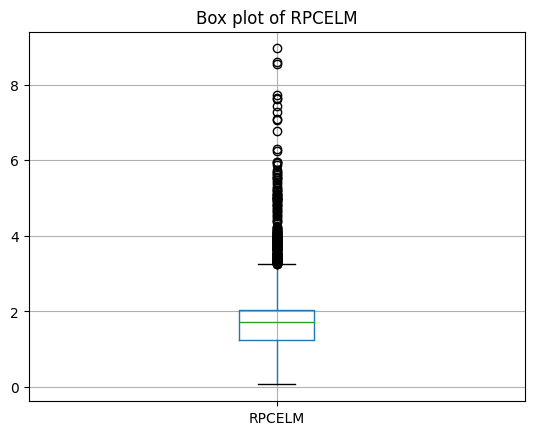

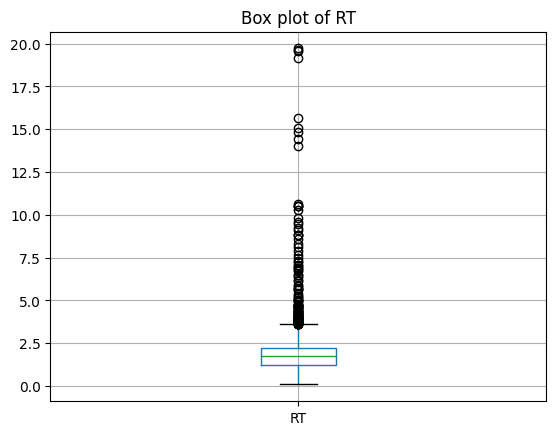

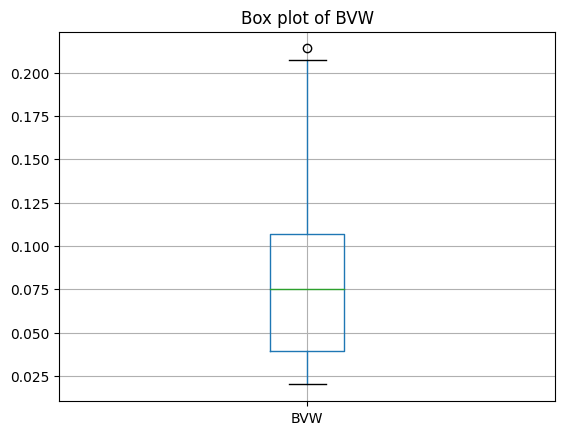

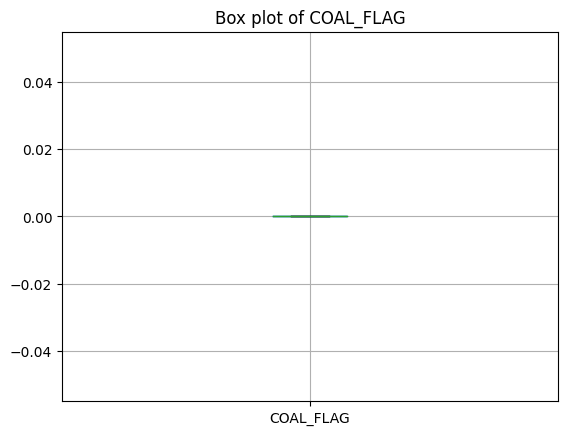

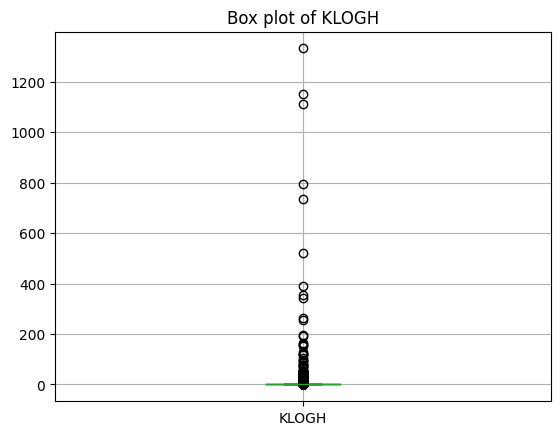

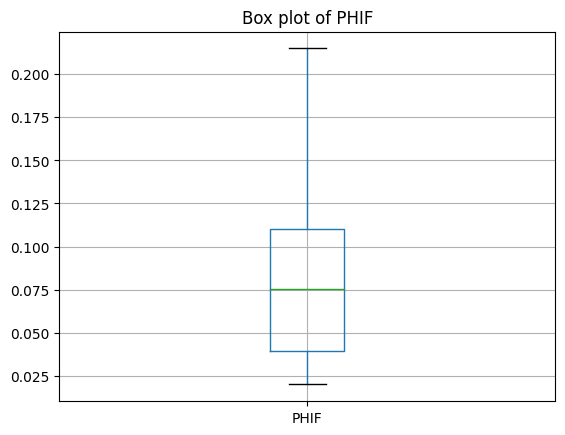

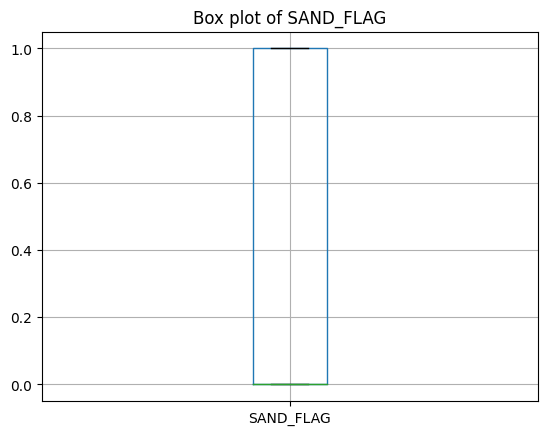

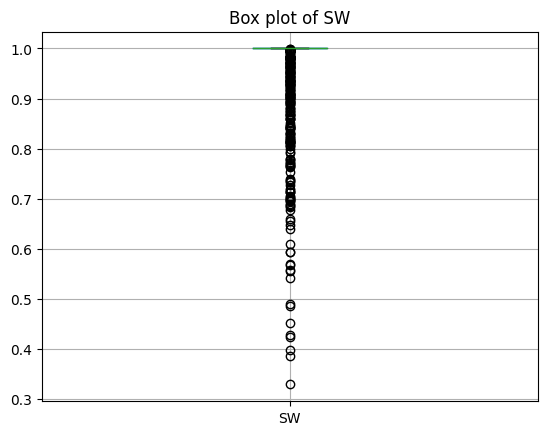

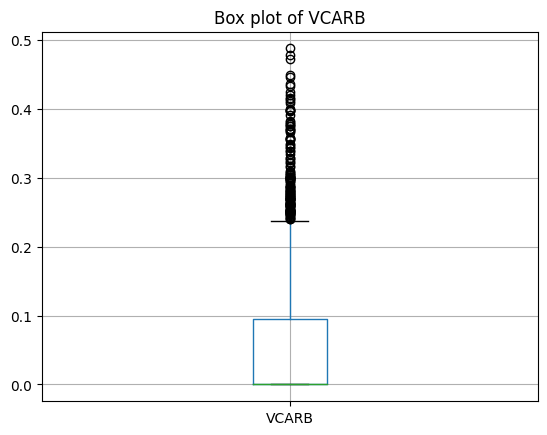

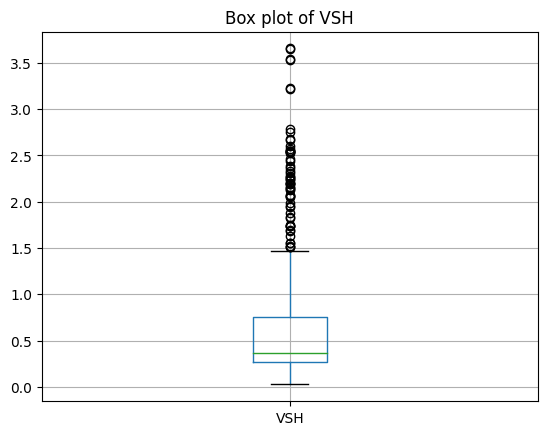

In [7]:
# plot boxplot to check for outliers

for column in ita_well1:
    plt.figure()  # Creates a new figure
    ita_well.boxplot([column])  # Creates a boxplot for the column
    plt.title(f'Box plot of {column}')  # Sets the title of the plot
plt.show()

In [8]:
# removing outliers from dataset
ita_well_filtered = ita_well1.copy()

for column in ita_well_filtered.columns:
    Q1 = ita_well_filtered[column].quantile(0.25)
    Q3 = ita_well_filtered[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data frame to remove outliers
    ita_well_filtered = ita_well_filtered[(ita_well_filtered[column] >= lower_bound) & (ita_well_filtered[column] <= upper_bound)]

In [9]:
ita_well_filtered.describe()

,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,GR,NPHI,...,RPCELM,RT,BVW,COAL_FLAG,KLOGH,PHIF,SAND_FLAG,SW,VCARB,VSH
count,1544.000000,1544.000000,1544.000000,1544.000000,1544.0,1544.000000,1544.000000,1544.000000,1544.000000,1544.000000,...,1544.000000,1544.000000,1544.000000,1544.0,1544.000000,1544.000000,1544.0,1544.0,1544.000000,1544.000000
mean,2.564847,2.566715,2.568643,2.568517,8.5,8.640281,0.060166,75.237881,74.844221,0.155886,...,1.771992,1.842500,0.055256,0.0,0.023642,0.055256,0.0,1.0,0.061471,0.500081
std,0.038031,0.037343,0.037828,0.038614,0.0,0.021195,0.007281,3.461835,26.166839,0.035037,...,0.329112,0.400830,0.024339,0.0,0.033202,0.024339,0.0,0.0,0.078455,0.217971
min,2.405200,2.459600,2.460300,2.466400,8.5,8.593800,0.039100,66.149400,30.031800,0.089500,...,0.680400,0.588000,0.020000,0.0,0.001000,0.020000,0.0,1.0,0.000000,0.125300
25%,2.535475,2.537775,2.536575,2.537300,8.5,8.625000,0.055300,72.710425,51.485425,0.126975,...,1.550300,1.579775,0.031700,0.0,0.001000,0.031700,0.0,1.0,0.000000,0.304125
50%,2.570150,2.571100,2.575100,2.573500,8.5,8.625000,0.059300,74.772300,63.918500,0.146250,...,1.768100,1.822150,0.055700,0.0,0.009400,0.055700,0.0,1.0,0.010450,0.412550
75%,2.595100,2.597650,2.599500,2.600325,8.5,8.671900,0.064300,77.192825,102.864125,0.185550,...,2.004125,2.099075,0.076325,0.0,0.032700,0.076325,0.0,1.0,0.114075,0.732375
max,2.655000,2.669900,2.655100,2.692900,8.5,8.682300,0.079900,84.286500,125.898000,0.254700,...,2.572800,3.021700,0.103400,0.0,0.198400,0.103400,0.0,1.0,0.300600,0.924200


In [10]:
# feature selection
# remove log measurements that are similar or not useful based on review of previous literature

ita_well_log= ita_well_filtered.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS',
                   'VSH', 'BVW', 'SAND_FLAG', 'RPCEHM', 'RPCELM', 'RM','COAL_FLAG','SAND_FLAG','VCARB'], 1)

C:\Users\godwi\AppData\Local\Temp\ipykernel_11132\586332875.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ita_well_log= ita_well_filtered.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS',


In [11]:
ita_well_log.head()

,CALI,DRHO,DT,GR,NPHI,PEF,RACEHM,RACELM,RD,RHOB,ROP,RT,KLOGH,PHIF,SW
488,8.6250,0.0698,68.2099,94.5679,0.1054,7.0959,2.2316,1.7552,1.5045,2.6426,19.7936,1.4833,0.0010,0.0200,1.0
544,8.6250,0.0609,72.8641,103.6055,0.2547,6.8556,1.4545,1.2940,1.7653,2.5937,19.7293,2.5439,0.0010,0.0377,1.0
633,8.6484,0.0412,73.6964,56.9845,0.1733,6.2861,1.5323,1.0160,1.7747,2.5528,20.0037,2.6949,0.0774,0.0609,1.0
634,8.6250,0.0488,73.3374,58.9277,0.1888,6.3847,1.5573,1.0182,1.7743,2.5794,19.9693,2.6633,0.0400,0.0458,1.0
635,8.6484,0.0560,73.1094,61.4723,0.1958,6.5272,1.5658,1.0208,1.7542,2.6002,19.9349,2.6455,0.0194,0.0340,1.0


In [12]:
# Define features and target variable

features = ita_well_log.columns[:-3]  # All columns except the last three
target = ita_well_log.columns[12]   # the twelveth column
print(features)
print(target)

Index(['CALI', 'DRHO', 'DT', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD',
       'RHOB', 'ROP', 'RT'],
      dtype='object')
KLOGH


In [13]:
# Model selection and training

# Split data into training validation and test sets

X = ita_well_log[['CALI', 'DRHO', 'DT', 'GR', 'NPHI', 'PEF',
                  'RACEHM', 'RACELM', 'RD','RHOB', 'ROP', 'RT']] 
yperm = ita_well_log[['KLOGH']]  #permeability

# split into train and test set first in the ratio 80:20

X_train, X_test, yperm_train, yperm_test = train_test_split(X,yperm,
                                                            test_size = 0.2, 
                                                            random_state = 42)

#further split the training data into training and validation sets in the rati 75:25.  
#Thus using 60% of the dataset for training, 20% for validation and 20% for testing.

itaX_train, X_val, itayperm_train, yperm_val = train_test_split(X_train, yperm_train,
                                                                test_size=0.25, random_state=42)



In [14]:
#checking the shapes of the training, validation and test set
print('shape of itaX_train {}'.format(itaX_train.shape))
print('shape of itayperm_train {}'.format(itayperm_train.shape))
print('shape of X_val {}'.format(X_val.shape))
print('shape of yperm_val {}'.format(yperm_val.shape))
print('shape of X_test {}'.format(X_test.shape))
print('shape of yperm_test {}'.format(yperm_test.shape))

shape of itaX_train (926, 12)
shape of itayperm_train (926, 1)
shape of X_val (309, 12)
shape of yperm_val (309, 1)
shape of X_test (309, 12)
shape of yperm_test (309, 1)


In [15]:
# Create the SVR model with RBF kernel using randomly chosen hyperparameters
Ita_svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma=0.01)
#model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model
Ita_svm_model.fit(itaX_train, itayperm_train)

# Validate the model
y_val_pred = Ita_svm_model.predict(X_val)
val_error = mean_squared_error(yperm_val, y_val_pred).round(5)


print(f"Validation MSE: {val_error}")
print('Mean Absolute Error:', metrics.mean_absolute_error
      (yperm_val, y_val_pred).round(5))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error
                                          (yperm_val, y_val_pred)).round(5))

Validation MSE: 0.00681
Mean Absolute Error: 0.07818
Root Mean Squared Error: 0.08252


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Fine tuning model parameters to obtain the best hyperparameters
Ita_svm_model = SVR(kernel='rbf')
#Define the hyperparameters to tune
param_grid = {'C': [0.1, 1, 10, 100,1000], 'epsilon': [0.01, 0.1, 1],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} 

# Use GridSearchCV to find the best hyperparameters
Ita_grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

# Train the model using the training sets
Ita_grid.fit(itaX_train, itayperm_train)


# Print the best parameters
print("Best parameters found: ", Ita_grid.best_params_)


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.427 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.339 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 3/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.398 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.320 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.298 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.703 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.701 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.764 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.616 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.722 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.630 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.792 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.705 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.705 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.607 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.702 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.633 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.552 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.522 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.585 total time=   0.0s

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.522 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.1, gamma=1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 1/5] END C=1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.431 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.339 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.397 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.326 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.01, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 1/5] END C=1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.711 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.678 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 3/5] END C=1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.646 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.729 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END C=1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.737 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.807 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.751 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/5] END C=1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.666 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.780 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 4/5] END C=1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.727 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.739 total time=   0.0s
[CV 1/5] END C=1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.635 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.597 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.683 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.604 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.607 total time=   0.0s
[CV 1/5] END C=1, epsilon=0.1, gamma=1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=1, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=1, epsilon=0.1, g

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 2/5] END C=1, epsilon=1, gamma=0.0001, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1, epsilon=1, gamma=0.0001, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=1, epsilon=1, gamma=0.0001, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=1, epsilon=1, gamma=0.0001, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.01, gamma=1, kernel=rbf;, score=0.431 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.01, gamma=1, kernel=rbf;, score=0.339 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.01, gamma=1, kernel=rbf;, score=0.397 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.01, gamma=1, kernel=rbf;, score=0.326 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.01, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 1/5] END C=10, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.706 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.716 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.634 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.765 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 2/5] END C=10, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.777 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.728 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.688 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.764 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 2/5] END C=10, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.807 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.780 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.708 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.669 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.752 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.691 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 1/5] END C=10, epsilon=0.1, gamma=1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=10, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=10, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=10, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=10, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=10, epsilon=0.1, gamma=0.0

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 1/5] END C=100, epsilon=0.01, gamma=1, kernel=rbf;, score=0.431 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.01, gamma=1, kernel=rbf;, score=0.339 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.01, gamma=1, kernel=rbf;, score=0.397 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.01, gamma=1, kernel=rbf;, score=0.326 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.01, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 1/5] END C=100, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.706 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 2/5] END C=100, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.716 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.634 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.826 total time=   0.1s
[CV 2/5] END C=100, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.754 total time=   0.1s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.672 total time=   0.1s
[CV 4/5] END C=100, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.777 total time=   0.1s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=100, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.665 total time=   0.1s
[CV 1/5] END C=100, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.822 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.765 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=100, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.836 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.837 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.829 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=100, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.754 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.705 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.805 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.762 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.746 total time=   0.0s
[CV 1/5] END C=100, epsilon=0.1, gamma=1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=100, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 3/5] END C=100, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=100, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=100, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=100, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=100, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=100, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=100, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] E

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 3/5] END C=1000, epsilon=0.01, gamma=1, kernel=rbf;, score=0.397 total time=   0.0s
[CV 4/5] END C=1000, epsilon=0.01, gamma=1, kernel=rbf;, score=0.326 total time=   0.0s
[CV 5/5] END C=1000, epsilon=0.01, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 1/5] END C=1000, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.706 total time=   0.0s
[CV 2/5] END C=1000, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.0s
[CV 3/5] END C=1000, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END C=1000, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.716 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 5/5] END C=1000, epsilon=0.01, gamma=0.1, kernel=rbf;, score=0.634 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1000, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.852 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1000, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.777 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1000, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.642 total time=   0.5s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1000, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.741 total time=   0.3s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1000, epsilon=0.01, gamma=0.01, kernel=rbf;, score=0.568 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1000, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.871 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1000, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.814 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1000, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.853 total time=   0.4s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1000, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.867 total time=   0.3s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1000, epsilon=0.01, gamma=0.001, kernel=rbf;, score=0.877 total time=   0.4s
[CV 1/5] END C=1000, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.808 total time=   0.1s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1000, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.747 total time=   0.1s
[CV 3/5] END C=1000, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.1s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1000, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.826 total time=   0.1s
[CV 5/5] END C=1000, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=0.803 total time=   0.1s
[CV 1/5] END C=1000, epsilon=0.1, gamma=1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1000, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1000, epsilon=0.1, gamma=1, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=1000, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=1000, epsilon=0.1, gamma=1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=1000, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1000, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1000, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-6.183 total time=   0.0s


C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV 4/5] END C=1000, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=1000, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=1000, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1000, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1000, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=1000, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3.919 total time=   0.0s
[CV 5/5] END C=1000, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3.198 total time=   0.0s
[CV 1/5] END C=1000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-4.989 total time=   0.0s
[CV 2/5] END C=1000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-6.902 total time=   0.0s
[CV 3/5] END C=1000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-6.183 total time=   0.0s
[CV 4/5] END C=1000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-3.919 total time=   0.

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best parameters found:  {'C': 1000, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


In [17]:
# Evaluate on validation set
val_predictions = Ita_grid.predict(X_val)
val_mse = metrics.mean_squared_error(yperm_val, val_predictions)



print(f"Validation MSE: {val_mse:.5f}")
print('Mean Absolute Error:', metrics.mean_absolute_error
      (yperm_val, val_predictions).round(5))  
print('Root Mean Squared Error:', np.sqrt
      (metrics.mean_squared_error(yperm_val, val_predictions)).round(5))


Validation MSE: 0.00012
Mean Absolute Error: 0.0067
Root Mean Squared Error: 0.01093


In [18]:
#Evaluate model on test set to predict permeability
Ita_model = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=0.001)  
Ita_model.fit(X_train, yperm_train)

#predict the target for the test dataset
yperm_pred = Ita_model.predict(X_test)


# evaluate predictions

print("R^2: {:.5f}".format(Ita_model.score(X_train, yperm_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error
      (yperm_test, yperm_pred).round(5))  
print('Mean Squared Error:', metrics.mean_squared_error
      (yperm_test, yperm_pred).round(5))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error
                                          (yperm_test, yperm_pred)).round(5))

C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R^2: 0.89299
Mean Absolute Error: 0.00681
Mean Squared Error: 0.00014
Root Mean Squared Error: 0.01176


In [19]:
# Feature Importance analysis
# using permutation importance to calculate the importance 
# of each feature to the model

r = permutation_importance(Ita_model, X, yperm, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")



GR      1.109 +/- 0.048
RHOB    0.531 +/- 0.018
RD      0.087 +/- 0.006
RT      0.062 +/- 0.004
RACEHM  0.053 +/- 0.003
DT      0.042 +/- 0.004
ROP     0.040 +/- 0.005
NPHI    0.038 +/- 0.003
RACELM  0.035 +/- 0.005
PEF     0.029 +/- 0.003
DRHO    0.004 +/- 0.001
CALI    0.000 +/- 0.000


In [20]:
# using feature importance with Random forest to evaluate 
# the importance of the features to the model

# Feature Selection (1. Candidate Features)
candidate_features = ["GR", "RACELM", "DRHO", "RT", "RD", "PEF",
                      "RHOB", "DT", "CALI", "RACEHM", "ROP", "NPHI"]
Xsel= ita_well_log[candidate_features]
yperm= ita_well_log['KLOGH']

# Feature Selection (2. Importance Analysis with Random Forest)
def evaluate_feature_importance(Xsel, yperm):
  model = RandomForestRegressor()
  model.fit(Xsel, yperm)
  return model.feature_importances_

feature_importances = {}
for feature in candidate_features:
  Xsel_train, Xsel_test, yperm_train, yperm_test = train_test_split(Xsel, yperm,
                                                                    test_size=0.3, 
                                                                    random_state=42)
  feature_importances[feature] = evaluate_feature_importance(Xsel_train, yperm_train)
# Get feature importances
feature_importances = evaluate_feature_importance(Xsel_train, yperm_train)

# Create a dictionary of feature importances
feature_importance_dict = dict(zip(candidate_features, feature_importances))
# Print the feature importances
for feature, importance in feature_importance_dict.items():
    print(f"Feature: {feature}, Importance: {importance}")

Feature: GR, Importance: 0.586216344446766
Feature: RACELM, Importance: 0.020978704865725322
Feature: DRHO, Importance: 0.004784677536116467
Feature: RT, Importance: 0.009978941366916285
Feature: RD, Importance: 0.007496796094369511
Feature: PEF, Importance: 0.015800750249993292
Feature: RHOB, Importance: 0.32377773634031815
Feature: DT, Importance: 0.007537284946040502
Feature: CALI, Importance: 0.0010659094219930983
Feature: RACEHM, Importance: 0.00834419581891562
Feature: ROP, Importance: 0.008975358582154766
Feature: NPHI, Importance: 0.005043300330690851


In [22]:
# Identifying the 5 most important log measurements
# Define the top features from both feature importance analysis technique

top_features = ["DT", "GR", "PEF", "RACELM", "RD", "RHOB","ROP"] 

# Define a function to evaluate the model
def evaluate_model(Ita_model, X_test, yperm_test):
    y_pred = Ita_model.predict(X_test)
    rmse = mean_squared_error(yperm_test, y_pred, squared=False)
    r2 = r2_score(yperm_test, y_pred)
    mae = mean_absolute_error(yperm_test, y_pred)
    mse = mean_squared_error(yperm_test, y_pred)
    return {"RMSE": rmse, "R2_score": r2, "MAE": mae, "MSE": mse}

# Initialize a list to store the results
results = []

# Iterate over all possible combinations of the top features
for r in [4, 5, 6]:
    for features in itertools.combinations(top_features, r):
        # Select the current combination of features
        X1 = Xsel[list(features)]
        
        # Split the data into training and testing sets
        X1_train, X1_test, y_train, y_test = train_test_split(X1, yperm, test_size=0.3,
                                                              random_state=42)
        
        # Create and train the model
       
        Ita_model.fit(X1_train, y_train)
        
        # Evaluate the model and store the results
        result = evaluate_model(Ita_model, X1_test, yperm_test)
        result['features'] = features
        results.append(result)

# Sort the results by MSE
results.sort(key=lambda x: x['MSE'])

# Print the results
for result in results:
    print(f"Features: {result['features']}, RMSE: {result['RMSE']:.5f}, R2_score: {result['R2_score']:.5f}, MAE: {result['MAE']:.5f}, MSE: {result['MSE']:.5f}")



Features: ('GR', 'PEF', 'RACELM', 'RD', 'RHOB', 'ROP'), RMSE: 0.01096, R2_score: 0.89123, MAE: 0.00637, MSE: 0.00012
Features: ('DT', 'GR', 'PEF', 'RACELM', 'RHOB', 'ROP'), RMSE: 0.01097, R2_score: 0.89102, MAE: 0.00703, MSE: 0.00012
Features: ('GR', 'RACELM', 'RD', 'RHOB', 'ROP'), RMSE: 0.01111, R2_score: 0.88812, MAE: 0.00648, MSE: 0.00012
Features: ('DT', 'GR', 'PEF', 'RD', 'RHOB', 'ROP'), RMSE: 0.01119, R2_score: 0.88654, MAE: 0.00699, MSE: 0.00013
Features: ('GR', 'PEF', 'RACELM', 'RHOB', 'ROP'), RMSE: 0.01119, R2_score: 0.88648, MAE: 0.00717, MSE: 0.00013
Features: ('GR', 'RACELM', 'RHOB', 'ROP'), RMSE: 0.01121, R2_score: 0.88605, MAE: 0.00706, MSE: 0.00013
Features: ('DT', 'GR', 'PEF', 'RHOB', 'ROP'), RMSE: 0.01122, R2_score: 0.88585, MAE: 0.00706, MSE: 0.00013
Features: ('GR', 'RD', 'RHOB', 'ROP'), RMSE: 0.01128, R2_score: 0.88475, MAE: 0.00697, MSE: 0.00013
Features: ('GR', 'PEF', 'RD', 'RHOB', 'ROP'), RMSE: 0.01135, R2_score: 0.88321, MAE: 0.00716, MSE: 0.00013
Features: ('DT

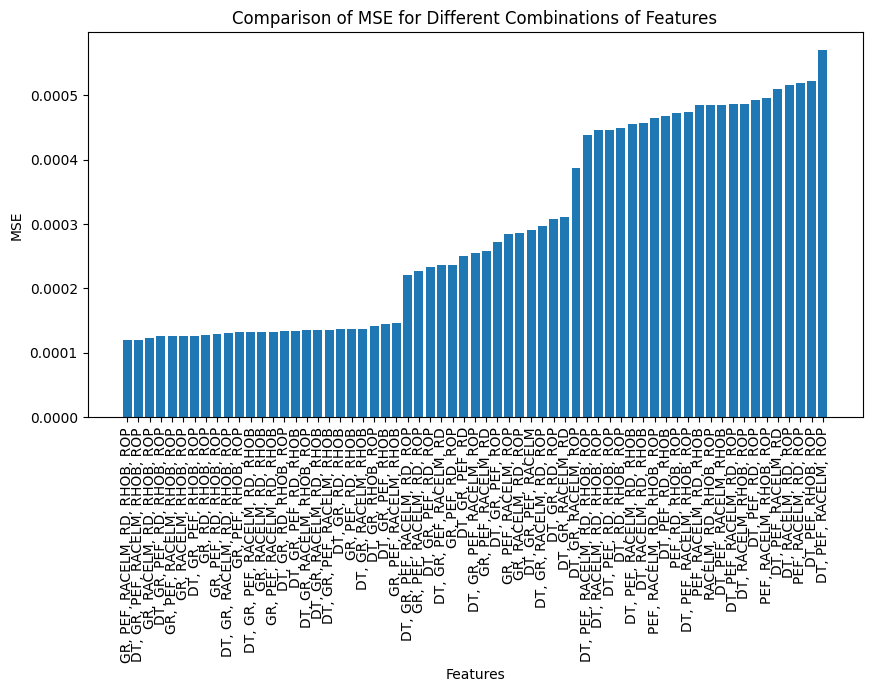

In [23]:
# Plot the MSE for each combination of features
plt.figure(figsize=(10, 5))
plt.bar(range(len(results)), [result['MSE'] for result in results], tick_label=[', '.join(result['features']) for result in results])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('MSE')
plt.title('Comparison of MSE for Different Combinations of Features')
plt.show()

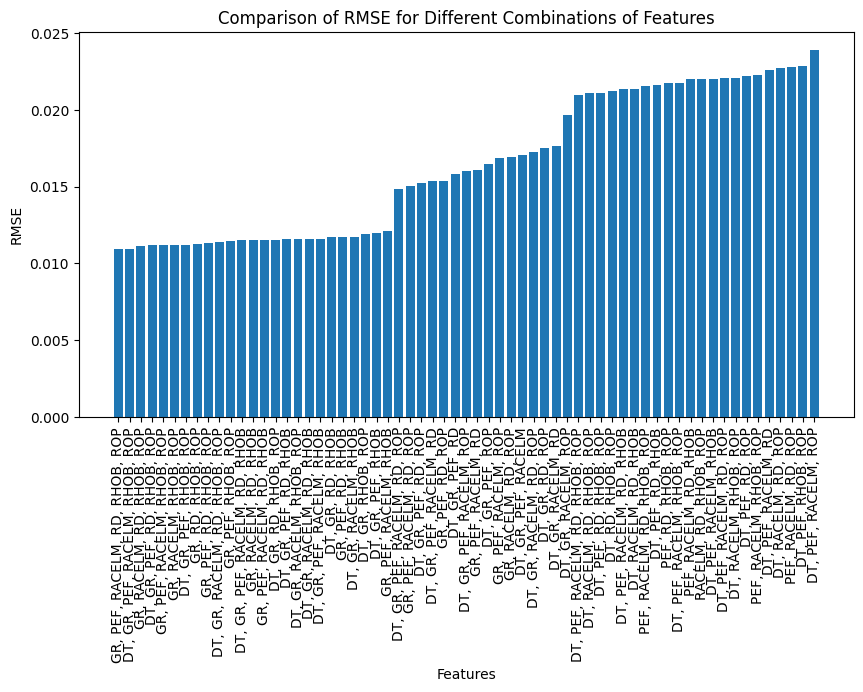

In [24]:
# Plot the RMSE for each combination of features
plt.figure(figsize=(10, 5))
plt.bar(range(len(results)), [result['RMSE'] for result in results], tick_label=[', '.join(result['features']) for result in results])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Combinations of Features')
plt.show()

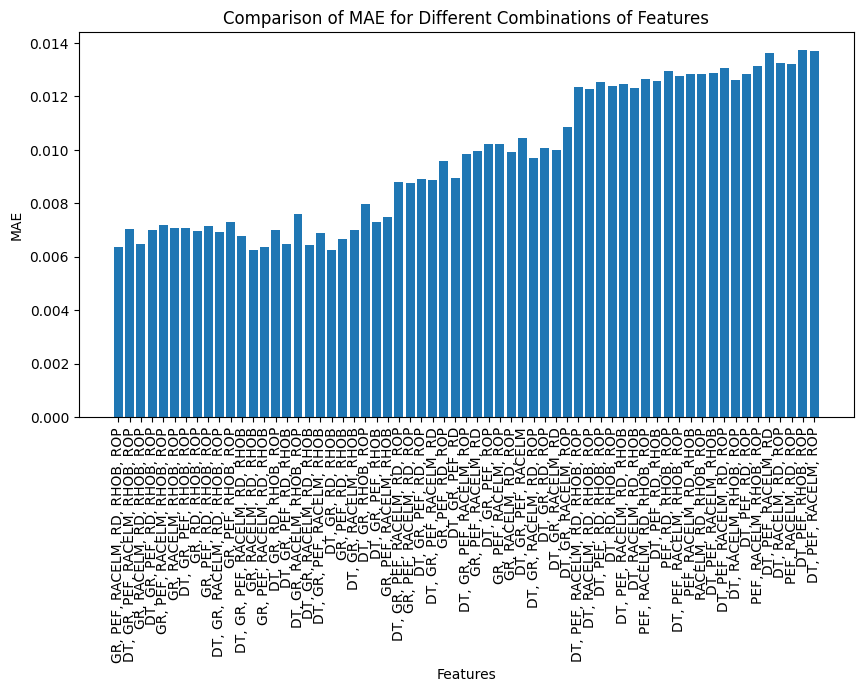

In [25]:
# Plot the MAE for each combination of features
plt.figure(figsize=(10, 5))
plt.bar(range(len(results)), [result['MAE'] for result in results], tick_label=[', '.join(result['features']) for result in results])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('MAE')
plt.title('Comparison of MAE for Different Combinations of Features')
plt.show()

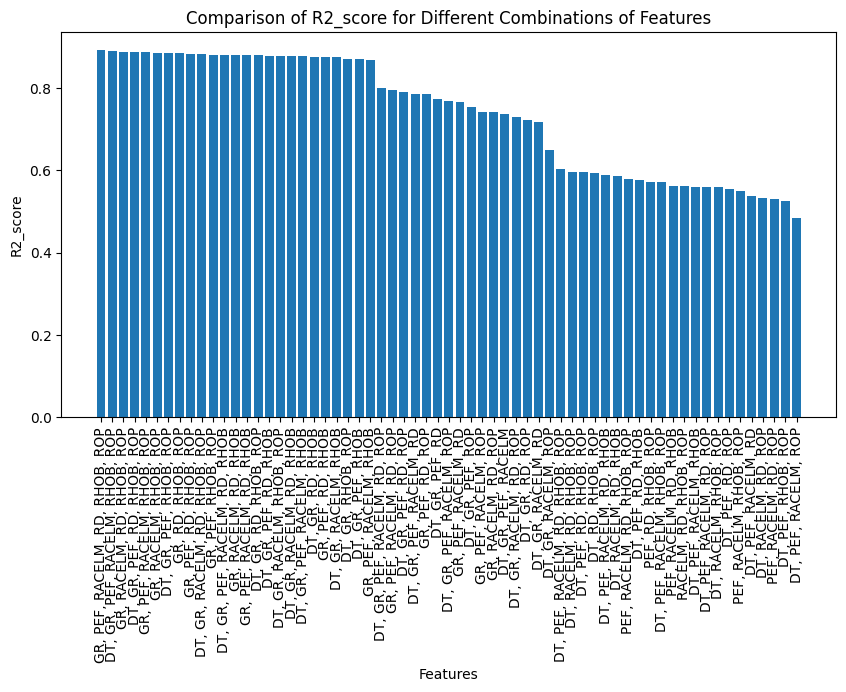

In [26]:
# Plot the R2_Score for each combination of features
plt.figure(figsize=(10, 5))
plt.bar(range(len(results)), [result['R2_score'] for result in results], tick_label=[', '.join(result['features']) for result in results])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('R2_score')
plt.title('Comparison of R2_score for Different Combinations of Features')
plt.show()

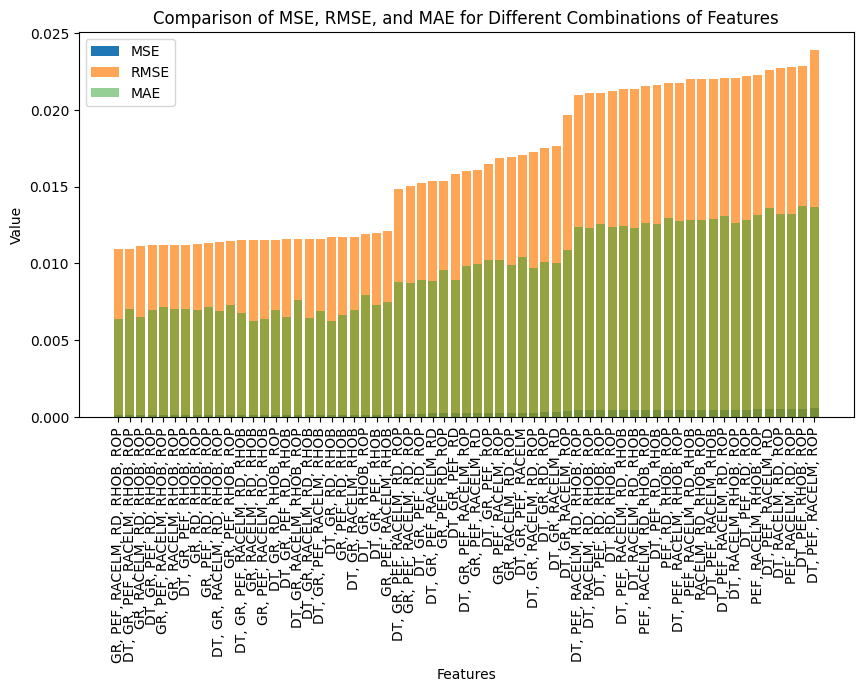

In [27]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Create a bar chart for MSE
ax.bar(range(len(results)), [result['MSE'] for result in results], label='MSE')

# Create a bar chart for RMSE
ax.bar(range(len(results)), [result['RMSE'] for result in results], label='RMSE', alpha=0.7)

# Create a bar chart for MAE
ax.bar(range(len(results)), [result['MAE'] for result in results], label='MAE', alpha=0.5)

# Set the x-ticks and x-tick labels
ax.set_xticks(range(len(results)))
ax.set_xticklabels([', '.join(result['features']) for result in results], rotation=90)

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Value')
ax.set_title('Comparison of MSE, RMSE, and MAE for Different Combinations of Features')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [28]:
# test the model on a different well using the most important selected log measurements 
# Load dataset
well_F_11 = pd.read_csv('well11.csv')


In [29]:
# test the model on a different well using the most important selected log measurements 
# Load dataset
well_F_11 = pd.read_csv('well11.csv')
#Droping irrelevant features
new_well = well_F_11.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS',
                   'VSH', 'BVW', 'SAND_FLAG', 'RPCEHM', 'RPCELM', 'RM','COAL_FLAG','SAND_FLAG','CARB_FLAG', 
                    'DTS', 'PHIF','SW' ], 1)
# solving the missing data problem, we remove all the missing data
Ita_new_well = new_well.dropna()
# Define features and target variable
Xnew = Ita_new_well[['GR','PEF','RACELM','RD','RHOB','ROP']] 
yactualnew = Ita_new_well[['KLOGH']]
#predict the permeability 
X2_train, X2_test, y2_train, y2_test = train_test_split(Xnew, yactualnew, test_size=0.3, random_state=42)
ita2model = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=0.001) 
ita2model.fit(X2_train, y2_train)
ita2model.fit(Xnew, yactualnew)
permpred = ita2model.predict(Xnew)
# evaluate predictions

print('Mean Absolute Error:', metrics.mean_absolute_error(yactualnew, permpred))  
print('Mean Squared Error:', metrics.mean_squared_error(yactualnew, permpred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yactualnew, permpred)))
print("R^2: {:.5f}".format(ita2model.score(Xnew, yactualnew)))

C:\Users\godwi\AppData\Local\Temp\ipykernel_11132\474301590.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  new_well = well_F_11.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS',
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\godwi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 50.28673651121993
Mean Squared Error: 19512.90301566667
Root Mean Squared Error: 139.6885930048215
R^2: 0.68280
